# Differentiable Fluid Simulations with Φ<sub>Flow</sub>

... now a more complex example with fluid simulations (Navier-Stokes) ...


In [1]:
!pip install --upgrade --quiet phiflow
from phi.flow import *  # The Dash GUI is not supported on Google Colab, ignore the warning
import pylab

/home/thuerey/anaconda3/envs/tf/lib/python3.8/_collections_abc.py:743: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  for key in self._mapping:
/home/thuerey/anaconda3/envs/tf/lib/python3.8/_collections_abc.py:744: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  yield (key, self._mapping[key])
/home/thuerey/phiflow/phi/viz/display.py:80: UserWarning: GUI is disabled because of missing dependencies: No module named 'imageio'. To install all dependencies, run $ pip install phiflow[gui]
  warnings.warn('GUI is disabled because of missing dependencies: %s. To install all dependencies, run $ pip install phiflow[gui]' % import_error)


## Setting up the simulation

Like before ...
But now let's set up four fluid simulations that run in parallel, i.e. a mini batch similar to DL training. In phiflow we can directly pass a `batch_size=4` parameter to the `Fluid` object. Each fluid simulation is fully independent. In this case they differ by having circular Inflows at different locations.

Like before, let's plot the marker density after a few steps of simulation (each call to `step()` now updates all four simulations). Note that the boundaries between the four simulations are not visible in the image, but it shows four completely separate density states. The different inflow positions in conjunction with the solid wall boundaries (zero Dirichlet for velocity, and Neumann for pressure), result in four  different end states of the simulation.

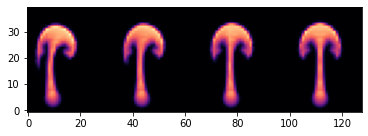

In [2]:
world = World()
fluid = world.add(Fluid(Domain([40, 32], boundaries=CLOSED), buoyancy_factor=0.05, batch_size=4), physics=IncompressibleFlow())
centers = [[5,10], [5,12], [5,14], [5,16]]
world.add(Inflow(Sphere(center=centers, radius=3), rate=0.2));

for frame in range(20):
  world.step(dt=1.5)

pylab.imshow(np.concatenate(fluid.density.data[...,0], axis=1), origin='lower', cmap='magma')

Now we see four simulations, 0 .. 3. Simulation `0`, with the curved plume on the far left, will be our reference, while the other three will be modified in the optimization procedure below.

## Differentiation

The simulation we just computed was using purely NumPy (non-differentiable) operations.
To enable differentiability, we need to build a TensorFlow graph that computes this result.

(Note, the first line is only necessary when running in environments that by default have newer tensorflow versions installed, e.g., `colab`. Uncomment if you're running this notebook there.)

In [4]:
# %tensorflow_version 1.x
from phi.tf.flow import *  # Causes deprecation warnings with TF 1.15
import pylab
session = Session(None)  # Used to run the TensorFlow graph

Could not load resample cuda libraries: CUDA binaries not found at /home/thuerey/phiflow/phi/tf/cuda/build/resample.so. Run "python setup.py cuda" to compile them


/home/thuerey/phiflow/phi/tf/__init__.py:7: UserWarning: TensorFlow 2 is not fully supported by PhiFlow.
  warnings.warn('TensorFlow 2 is not fully supported by PhiFlow.')
/home/thuerey/phiflow/phi/tf/flow.py:15: UserWarning: TensorFlow-CUDA solver is not available. To compile it, download phiflow sources and run
$ python setup.py tf_cuda
before reinstalling phiflow.
  warnings.warn("TensorFlow-CUDA solver is not available. To compile it, download phiflow sources and run\n$ python setup.py tf_cuda\nbefore reinstalling phiflow.")


Let's set up the simulation just like before. But now, we want to optimize the initial velocities so that all simulations arrive at a final state that is similar to the first simulation from the previous example. I.e., the state shown in the left-most image above.

This is a fairly tough task: we're producing diffent dynamics by changing the boundary conditions (the marker inflow position), and an optimizer should now find a single initial velocity state, that gives the same state as simulation `0` above at $t=30$. Thus, after 20 steps with $\Delta t=1.5$ the simulation should reproduce a different set of boundary conditions from the velocity state. It would be much easier to simply change the position of the marker inflow to arrive at this goal, but -- to make things a bit more difficult -- the inflow is _not_ a degree of freedom. The optimizer can only change the velocity $\mathbf{u}$ at time $t=0$.

To achieve this, we create a TensorFlow variable for the velocity at t=0.
It is initialized with zeros (like with the NumPy simulation above) and can later be used as a target for optimization.

In [5]:
world = World()
fluid = world.add(Fluid(Domain([40, 32], boundaries=CLOSED), buoyancy_factor=0.05, batch_size=4), physics=IncompressibleFlow())
world.add(Inflow(Sphere(center=centers, radius=3), rate=0.2));
fluid.velocity = variable(fluid.velocity)  # create TensorFlow variable
initial_state = fluid.state  # Remember the state at t=0 for later visualization
session.initialize_variables()

The simulation now contains variables in the initial state.
Since all later states depend on the value of the variable, the `step` method cannot directly compute concrete state values.
Instead, `world.step` will extend the TensorFlow graph by the operations needed to perform the step.

To execute the graph with actual data, we can use `session.run`, just like with regular TensorFlow 1.x. While `run` would usually be used to infer predictions from a learning model, it now executes the graph of simulation steps.

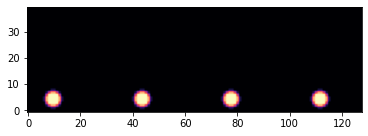

In [7]:
world.step()
pylab.imshow(np.concatenate(session.run(fluid.density).data[...,0], axis=1), origin='lower', cmap='magma')

Let's build a graph for the full simulation.

In [8]:
for frame in range(20):
  print('Building graph for frame %d' % frame)
  world.step(dt=1.5)

Building graph for frame 0
Building graph for frame 1
Building graph for frame 2
Building graph for frame 3
Building graph for frame 4
Building graph for frame 5
Building graph for frame 6
Building graph for frame 7
Building graph for frame 8
Building graph for frame 9
Building graph for frame 10
Building graph for frame 11
Building graph for frame 12
Building graph for frame 13
Building graph for frame 14
Building graph for frame 15
Building graph for frame 16
Building graph for frame 17
Building graph for frame 18
Building graph for frame 19


When calling `session.run` now, the full simulation is evaluated using TensorFlow operations.
This will take advantage of your GPU, if available.
If you compile Φ<sub>Flow</sub> with [CUDA support](https://github.com/tum-pbs/PhiFlow/blob/master/documentation/Installation_Instructions.md), the TensorFlow graph will use optimized operators for efficient simulation and training runs.

Computing frames...


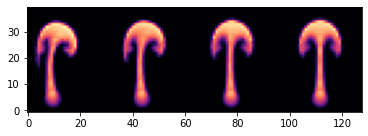

In [9]:
print('Computing frames...')
pylab.imshow(np.concatenate(session.run(fluid.density).data[...,0], axis=1), origin='lower', cmap='magma')

Next, we define the *loss* function (also called *cost* or *objective* function). This is the value we want to decrease via optimization.
For this example, we want the marker densities of all final simulation states to match the left-most one, called `target`.

For the optimizer, we choose gradient descent for this example.

Initial loss: 65.417107


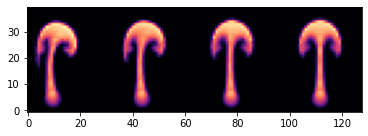

In [10]:
target = session.run(fluid.density).data[0,...]
loss = math.l2_loss(fluid.density.data[1:,...] - target)
optim = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)
session.initialize_variables()

print('Initial loss: %f' % session.run(loss))
pylab.imshow(np.concatenate(session.run(fluid.density).data[...,0], axis=1), origin='lower', cmap='magma')

With the loss and optimizer set up, all that's left is to run the actual optimization.

In [11]:
for optim_step in range(100):
  print('Running optimization step %d. %s' % (optim_step, '' if optim_step else 'The first step sets up the adjoint graph.'))
  _, loss_value = session.run([optim, loss])
  print('Loss: %f' % loss_value)

Running optimization step 0. The first step sets up the adjoint graph.
Loss: 65.417130
Running optimization step 1. 
Loss: 61.038616
Running optimization step 2. 
Loss: 55.527817
Running optimization step 3. 
Loss: 52.743553
Running optimization step 4. 
Loss: 50.682068
Running optimization step 5. 
Loss: 49.116470
Running optimization step 6. 
Loss: 47.600983
Running optimization step 7. 
Loss: 46.847046
Running optimization step 8. 
Loss: 47.156219
Running optimization step 9. 
Loss: 44.690727
Running optimization step 10. 
Loss: 43.885071
Running optimization step 11. 
Loss: 43.400795
Running optimization step 12. 
Loss: 44.021904
Running optimization step 13. 
Loss: 44.878464
Running optimization step 14. 
Loss: 42.061104
Running optimization step 15. 
Loss: 41.721771
Running optimization step 16. 
Loss: 42.422424
Running optimization step 17. 
Loss: 43.305126
Running optimization step 18. 
Loss: 41.030945
Running optimization step 19. 
Loss: 40.693314
Running optimization step 20.

The loss should have gone down significantly, from ca. 65 to below 34, and now we can visualize how well the reconstruction for the last frame turned out for simulations 1 to 3.

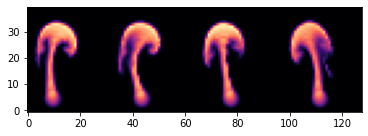

In [12]:
pylab.imshow(np.concatenate(session.run(fluid.density).data[...,0], axis=1), origin='lower', cmap='magma')

Naturally, the image on the left is the same (this is our reference), and the other three simulations now exhibit a noticeable curved shape towards the left. This is especially visible for the far left simulation (3), which was moving straight up in its original state, and now has an off-center plume shape that tries to match the reference on the left. Note that this simulation needs to "work" with a fixed inflow, hence it cannot simply "produce" marker density out of the blue to match the target. Also it needs to take into account how the non-linear model equations change the state of the system over the course of 20 time steps. The 

Now that the optimization has done its work, we can have a look at the now-optimized initial velocity field.

In [13]:
optimized_velocity_field = session.run(initial_state.velocity).at_centers()

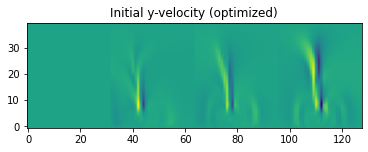

In [14]:
pylab.title('Initial y-velocity (optimized)')
pylab.imshow(np.concatenate(optimized_velocity_field.data[...,0], axis=1), origin='lower')

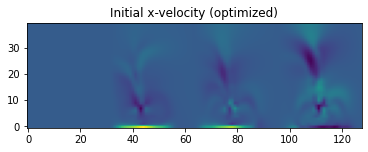

In [15]:
pylab.title('Initial x-velocity (optimized)')
pylab.imshow(np.concatenate(optimized_velocity_field.data[...,1], axis=1), origin='lower')

This notebook provided an introduction to running fluid simulations in NumPy and TensorFlow.
It demonstrated how to use the gradients provided by Φ<sub>Flow</sub> to run simple optimizations over the course of several timesteps.

For additional examples, e.g. coupling simulations with neural networks, please check the [other demos](https://github.com/tum-pbs/PhiFlow/tree/master/demos).